<a href="https://colab.research.google.com/github/devika-kla/RUL-Prediction/blob/main/rul_prediction_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PREDICTIVE MAINTENANCE OF AIRCRAFT ENGINE

**Introduction**

This project aims to forecast the remaining useful life (RUL) of aircraft engines based on the whole life cycle data, thereby improving maintenance planning and preventing disastrous failures. Using the NASA C-MAPSS data set is implemented and tested to determine the engine lifetime.

Our main focus will be on accurately predicting RUL values to prevent putting the engine at danger. Data analysis, data visualization and LSTM will all be covered in this notebook.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
#from pylab import rcParams
import math
import time
from tqdm import tqdm
import keras.models
import keras.layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import warnings
warnings.simplefilter('ignore')

In [2]:
# read training data - It is the aircraft engine run-to-failure data.
# read test data - It is the aircraft engine operating data without failure events recorded.
# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
data_train = pd.read_csv("PM_train.txt",sep=" ",header=None)
data_test = pd.read_csv("PM_test.txt",sep=" ",header=None)
data_RUL = pd.read_csv("PM_truth.txt",sep=" ",header=None)

train_copy = data_train
test_copy = data_test

In [3]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN


In [4]:
data_test

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


In [5]:
data_RUL

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN
...,...,...
95,137,NaN
96,82,NaN
97,59,NaN
98,117,NaN


In [6]:
# Drop missing data columns(redundant)
data_train.drop(columns=[26,27],inplace=True)
data_test.drop(columns=[26,27],inplace=True)
data_RUL.drop(columns=[1],inplace=True)

In [7]:
columns_train = ['unit_ID', 'cycles', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
data_train.columns = columns_train
data_train.describe()

,unit_ID,cycles,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [8]:
# Define a function to calculate the remaining useful life (RUL)
def add_rul(g):
    # Calculate the RUL as the difference between the maximum cycle value and the cycle value for each row
    g['RUL'] = max(g['cycles']) - g['cycles']
    return g

# Apply the add_rul function to the training data grouped by the unit ID
train = data_train.groupby('unit_ID').apply(add_rul)

In [9]:
train.head()

,unit_ID,cycles,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


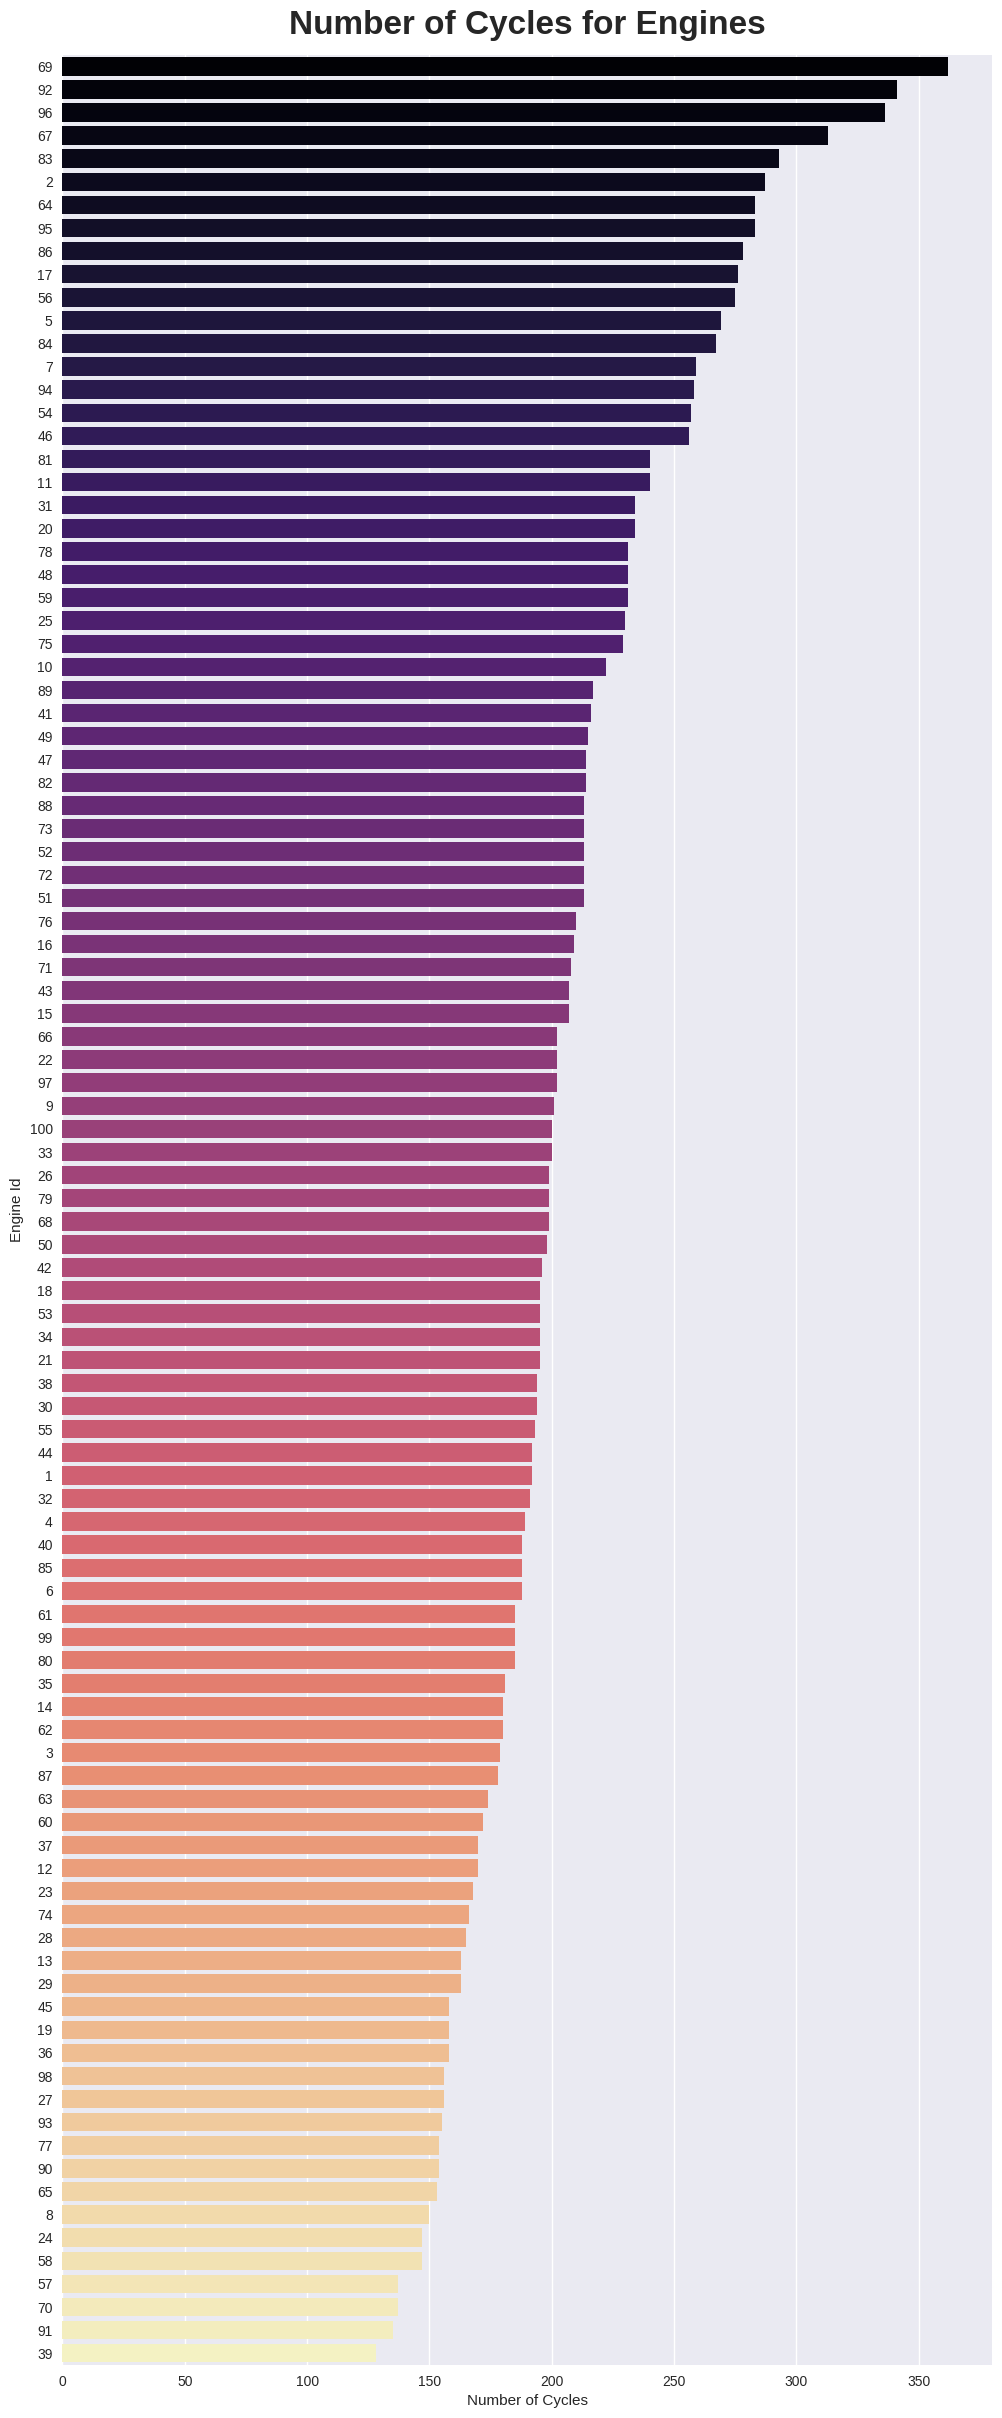

In [10]:
#to see the maximun time cycle of each unit
cnt_train = train[["unit_ID", "cycles"]].groupby("unit_ID").max().sort_values(by="cycles", ascending=False)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycles.values)

plt.style.use("seaborn")
plt.figure(figsize=(12, 30))
sns.barplot(x=list(cnt_val), y=list(cnt_ind), palette='magma')
plt.xlabel('Number of Cycles')
plt.ylabel('Engine Id')
plt.title('Number of Cycles for Engines', fontweight='bold', fontsize=24, pad=15)

plt.show()

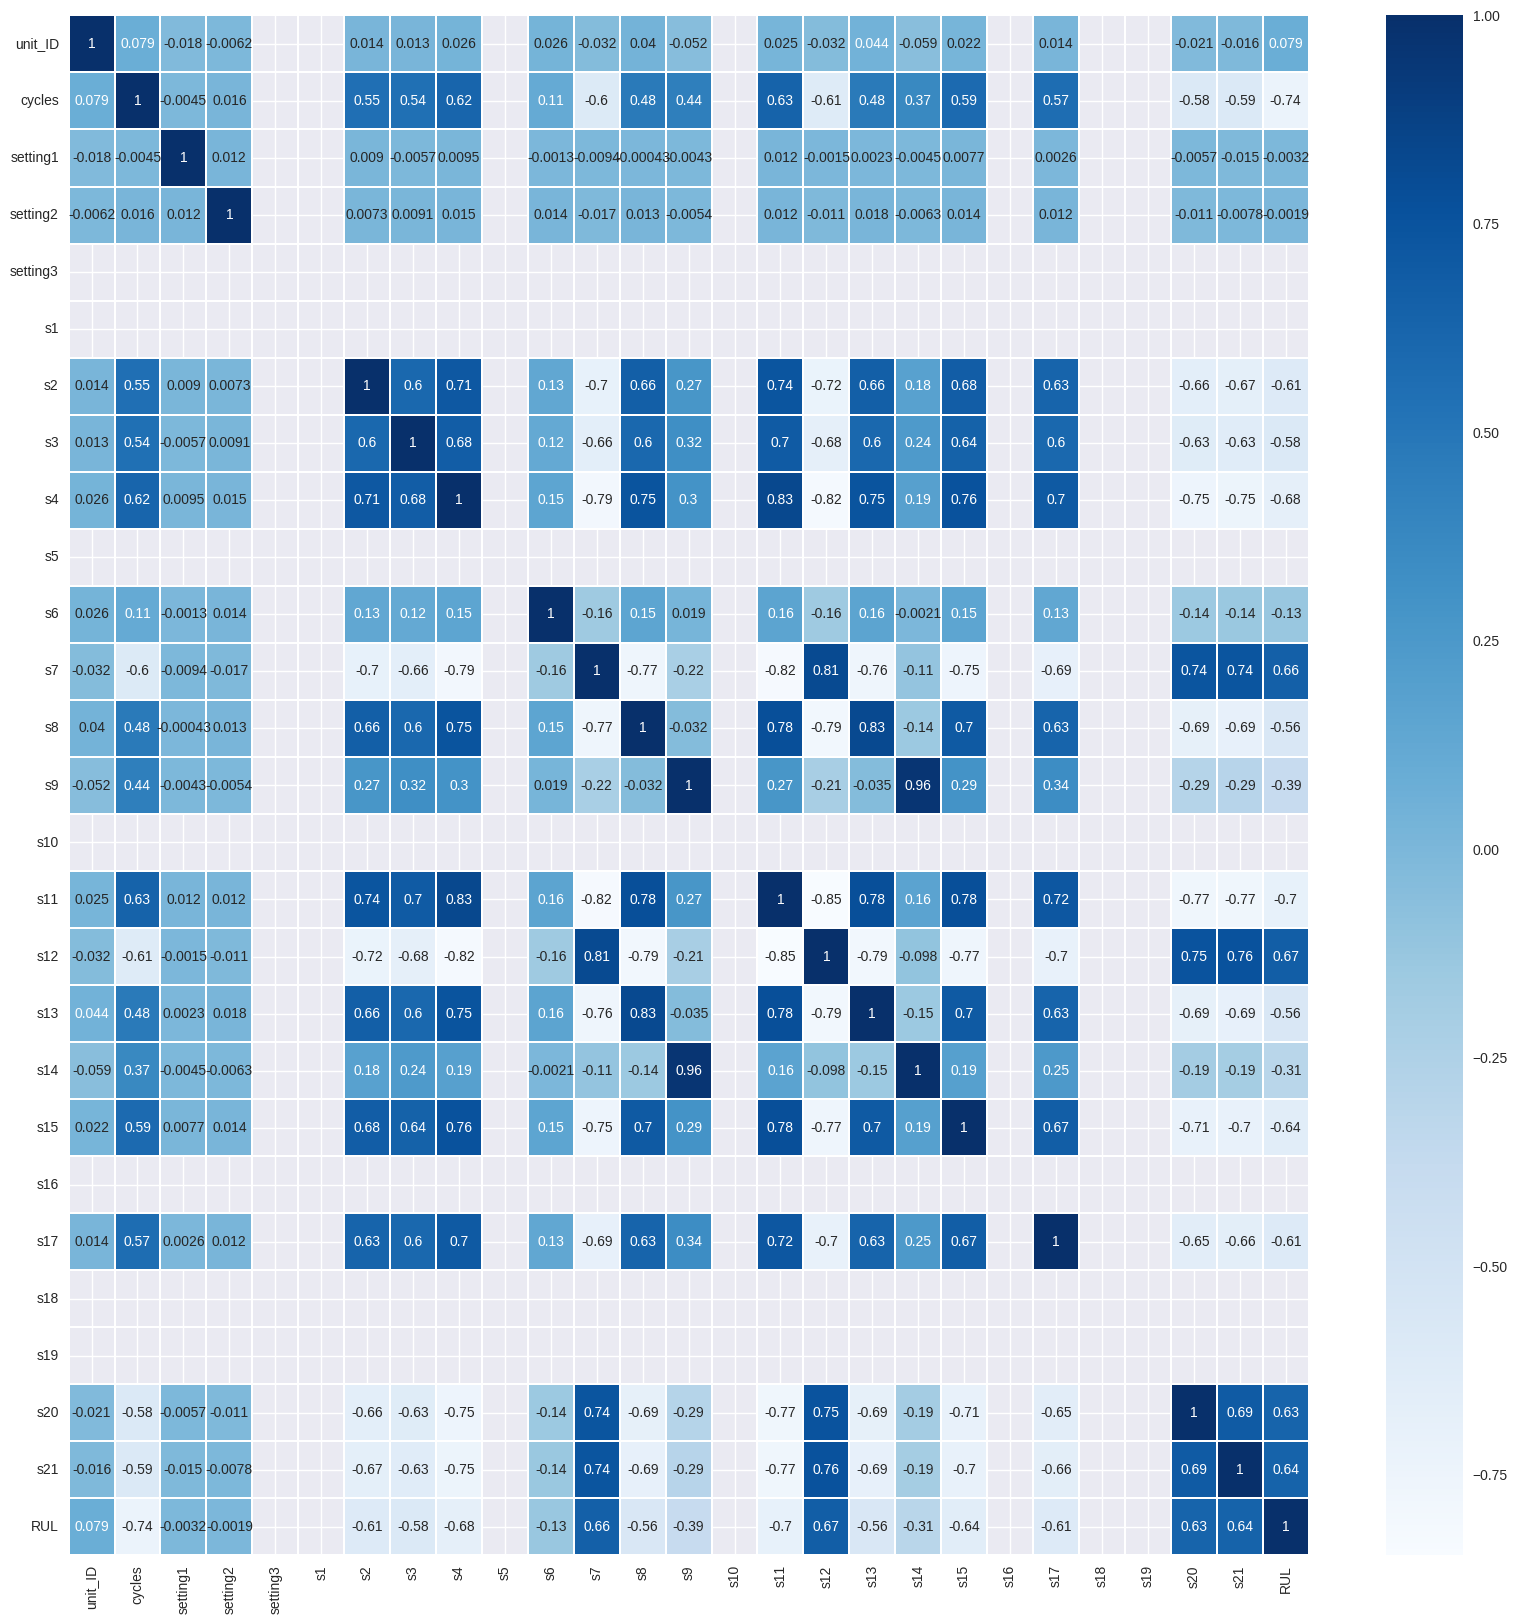

In [11]:
# the correlation between each features are computed.
# From this, if the correletion is zero, those features are removed as the values of those features are constant
sns.heatmap(train.corr(),annot=True,cmap='Blues',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [12]:
# Remove the irrelevent Features after correlation analysis
columns_to_remove = ['setting3', 's1', 's5','s10','s16','s18','s19']
train = train.drop(columns_to_remove,axis=1)

Takes datalength and earlyrul as input and creates target RUL.

This function takes in two arguments, data_length and early_rul. It returns an array that represents the remaining useful life (RUL) for each cycle in the input data. If the early_rul_duration is less than or equal to 0, then the target variable is a reversed range of data_length-1 to 0.

In [13]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)# returns an array of integers from data_length-1 down to 0
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
            #array consists of early_rul repeated early_rul_duration times and  integers from early_rul-1 down to 0

This function takes in input data and target data and processes them with a specified window length and shift size. The output_data is a numpy array with shape (num_batches, window_length, num_features). If target_data is not None, the function also outputs output_targets, a numpy array with shape (num_batches,) containing the target values for each batch.

In [14]:
# constructs batches of input data with corresponding target values, given parameters such as window length and shift.
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

This function processes the test data for a single engine in preparation for making predictions using a trained model. It takes in the test data for a single engine (test_data_for_an_engine), the window_length and shift parameters that were used in preparing the training data, and the number of test windows (num_test_windows) that should be processed.

In [15]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):

    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

The default option is to take only the last window of test data for each engine, which amounts to one window. However, if you set the number to a different value, that many windows from the last will be taken, and the final output will be the average of all the windows.

In [16]:
test_data = pd.read_csv("PM_test.txt", sep = "\s+", header = None,names=columns_train )
true_rul = pd.read_csv("PM_truth.txt", sep = '\s+', header = None)

window_length = 5
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['unit_ID','setting1','setting2','setting3', 's1', 's5','s10','s16','s18','s19']

train_data_first_column = data_train ["unit_ID"]
test_data_first_column = test_data["unit_ID"]

In [17]:
#Scale the data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(data_train.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

**Training data process:**

In [18]:
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Determine whether it is possible to extract training data with the specified window length.
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length= window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

**Test data process:**

In [19]:
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Determine whether it is possible to extract test data with the specified window length.
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [20]:
print("Processed training data shape: ", processed_train_data.shape) # shape=(no.of engines,no of time steps,no. of sensor readings)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed training data shape:  (20231, 5, 16)
Processed training ruls shape:  (20231,)
Processed test data shape:  (500, 5, 16)
True RUL shape:  (100,)


####**Splitting train data:**




In [21]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (16184, 5, 16)
Processed validation data shape:  (4047, 5, 16)
Processed train targets shape:  (16184,)
Processed validation targets shape:  (4047,)


# **LSTM**

LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems.

In [111]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

# Define the CNN architecture
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='tanh', input_shape=(window_length, 16)))
# model.add(Dropout(0.25))
# model.add(Conv1D(filters=16, kernel_size=3, activation='tanh'))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1)) # Output layer for regression task
# Create a Sequential model
model = Sequential()

# Add layers sequentially
model.add(Conv1D(filters=48, kernel_size=3, padding='causal', input_shape=(window_length,16)))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, padding='causal'))
model.add(Activation('tanh'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='elu'))

model.add(Dense(1))
# Compile the model
model.compile(optimizer=Adam(), loss='mse')
model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_53 (Conv1D)          (None, 5, 48)             2352      
                                                                 
 activation_37 (Activation)  (None, 5, 48)             0         
                                                                 
 dropout_40 (Dropout)        (None, 5, 48)             0         
                                                                 
 conv1d_54 (Conv1D)          (None, 5, 64)             9280      
                                                                 
 activation_38 (Activation)  (None, 5, 64)             0         
                                                                 
 dropout_41 (Dropout)        (None, 5, 64)             0         
                                                                 
 flatten_17 (Flatten)        (None, 320)             

In [112]:
# adjusts the learning rate during the training process based on epoch no., with the goal of improving the model's performance
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
#model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 20,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
253/253 - 2s - loss: 2035.1700 - val_loss: 433.0281 - lr: 0.0010 - 2s/epoch - 9ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
253/253 - 1s - loss: 436.0471 - val_loss: 298.3692 - lr: 0.0010 - 916ms/epoch - 4ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
253/253 - 1s - loss: 368.5081 - val_loss: 301.1891 - lr: 0.0010 - 923ms/epoch - 4ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/20
253/253 - 1s - loss: 351.1479 - val_loss: 280.4595 - lr: 0.0010 - 1s/epoch - 4ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/20
253/253 - 1s - loss: 335.1958 - val_loss: 271.7535 - lr: 0.0010 - 903ms/epoch - 4ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/20
253/253 - 1s - loss: 321.5894 - val_loss: 276.9866 - lr: 0.0010 - 1s/epoch - 5ms/step

Epoch 7: LearningRateSc

Measure the difference between predicted and actual values using
RMSE

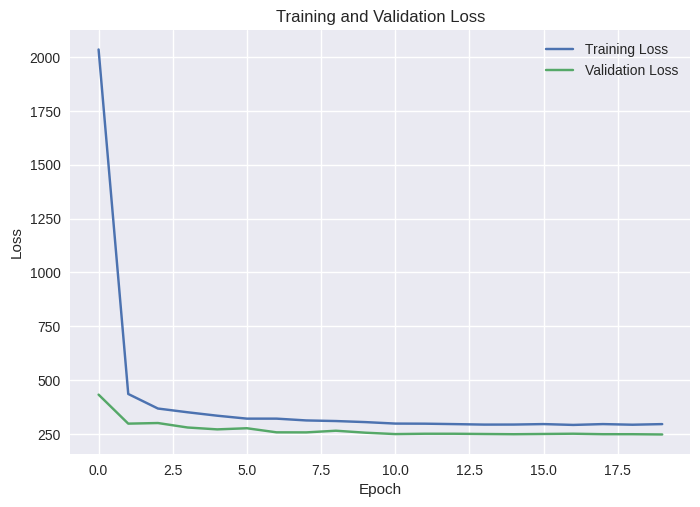

In [113]:
# Plot training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [115]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 0s 2ms/step
RMSE:  19.176861921535114


In [116]:
tf.keras.models.save_model(model, "FD001_LSTM_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  18.413358475818292


In [110]:
#It is a measure of the difference between the actual and predicted RUL values normalized by the standard deviation of the RUL.
#A higher S-score indicates a better prediction performance.

# def compute_s_score(rul_true, rul_pred):
#     diff = rul_pred - rul_true
#     return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
# s_score = compute_s_score(true_rul, preds_for_last_example)
# print("S-score: ", s_score)

In [117]:
from sklearn.metrics import mean_absolute_error

# Compute MAE
mae = mean_absolute_error(true_rul, preds_for_last_example)

# Compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(true_rul, preds_for_last_example)

print("MAE:", mae)
print("MAPE:", mape)


MAE: 13.30501513004303
MAPE: 24.087663608351246


####**Prediction :**

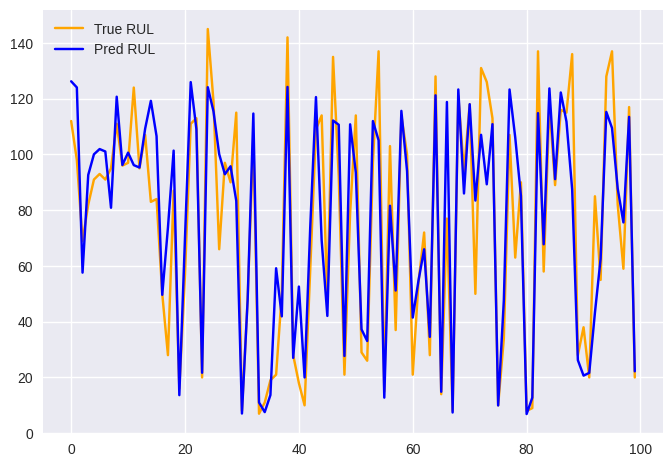

In [118]:
plt.plot(true_rul, label = "True RUL", color = "orange")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()